<a href="https://colab.research.google.com/github/dinesh0110/DM-Practical/blob/main/DM_Practicals%20notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



>### Practical 1 - MDP###



In [8]:
#Practical 1
import numpy as np
import random

### MDP Algorithms ###

def value_iteration(P, R, gamma=0.9, epsilon=1e-6):
    n_states, n_actions = R.shape[1], R.shape[0]
    V = np.zeros(n_states)
    while True:
        delta = 0
        for s in range(n_states):
            v = V[s]
            V[s] = max(sum(P[a, s, s1] * (R[a, s] + gamma * V[s1]) for s1 in range(n_states)) for a in range(n_actions))
            delta = max(delta, abs(v - V[s]))
        if delta < epsilon:
            break
    policy = np.argmax([[sum(P[a, s, s1] * (R[a, s] + gamma * V[s1]) for s1 in range(n_states)) for a in range(n_actions)] for s in range(n_states)], axis=1)
    return policy, V

def policy_iteration(P, R, gamma=0.9, epsilon=1e-6):
    n_states, n_actions = R.shape[1], R.shape[0]
    policy = np.zeros(n_states, dtype=int)
    V = np.zeros(n_states)
    while True:
        while True:
            delta = 0
            for s in range(n_states):
                v = V[s]
                V[s] = sum(P[policy[s], s, s1] * (R[policy[s], s] + gamma * V[s1]) for s1 in range(n_states))
                delta = max(delta, abs(v - V[s]))
            if delta < epsilon:
                break
        policy_stable = True
        for s in range(n_states):
            old_action = policy[s]
            policy[s] = np.argmax([sum(P[a, s, s1] * (R[a, s] + gamma * V[s1]) for s1 in range(n_states)) for a in range(n_actions)])
            if old_action != policy[s]:
                policy_stable = False
        if policy_stable:
            break
    return policy, V

def q_learning(P, R, gamma=0.9, alpha=0.1, epsilon=0.1, episodes=1000):
    n_states, n_actions = R.shape[1], R.shape[0]
    Q = np.zeros((n_states, n_actions))
    for _ in range(episodes):
        state = random.choice(range(n_states))
        while True:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(n_actions))
            else:
                action = np.argmax(Q[state])
            next_state = np.argmax(P[action, state])
            reward = R[action, state]
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state, best_next_action]
            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error
            if state == next_state:
                break
            state = next_state
    policy = np.argmax(Q, axis=1)
    return policy, Q

### Utility Functions ###

def validate_transition_matrix(P):
    assert np.allclose(P.sum(axis=2), 1), "Transition probabilities must sum to 1."

def validate_reward_matrix(R, P):
    assert R.shape == P.shape[:2], "Reward matrix dimensions must match the transition matrix."

def generate_random_mdp(n_states, n_actions):
    P = np.zeros((n_actions, n_states, n_states))
    for a in range(n_actions):
        for s in range(n_states):
            P[a, s, :] = np.random.dirichlet(np.ones(n_states))
    R = np.random.rand(n_actions, n_states)
    return P, R

### Example Usage ###

# Generate a random MDP
n_states = 3
n_actions = 2
P, R = generate_random_mdp(n_states, n_actions)

# Validate the MDP
validate_transition_matrix(P)
validate_reward_matrix(R, P)

# Solve the MDP using Value Iteration
policy_vi, V_vi = value_iteration(P, R)
print("Optimal Policy (Value Iteration):", policy_vi)
print("Value Function (Value Iteration):", V_vi)

# Solve the MDP using Policy Iteration
policy_pi, V_pi = policy_iteration(P, R)
print("Optimal Policy (Policy Iteration):", policy_pi)
print("Value Function (Policy Iteration):", V_pi)

# Solve the MDP using Q-Learning
policy_ql, Q_ql = q_learning(P, R)
print("Optimal Policy (Q-Learning):", policy_ql)
print("Q-Table (Q-Learning):", Q_ql)

Optimal Policy (Value Iteration): [1 0 0]
Value Function (Value Iteration): [4.62721478 4.88860481 5.0434772 ]
Optimal Policy (Policy Iteration): [1 0 0]
Value Function (Policy Iteration): [4.62721535 4.88860532 5.04347768]
Optimal Policy (Q-Learning): [0 0 0]
Q-Table (Q-Learning): [[4.23076394 4.15585996]
 [4.45664846 4.2141524 ]
 [4.56083248 4.06667042]]


### Practical 2 MONTE_CARLO ###

In [9]:
# Pract 2

import numpy as np
import random

def generate_episode(P, R, policy, n_states, max_steps=100):
    episode = []
    state = random.choice(range(n_states))
    for _ in range(max_steps):
        action = policy[state]
        next_state = np.random.choice(range(n_states), p=P[action, state])
        reward = R[action, state]
        episode.append((state, action, reward))
        state = next_state
        if state == next_state:  # Assuming episode ends when reaching a terminal state
            break
    return episode

def monte_carlo_control(P, R, n_states, n_actions, gamma=0.9, epsilon=0.1, episodes=1000):
    Q = np.zeros((n_states, n_actions))
    returns = { (s, a): [] for s in range(n_states) for a in range(n_actions) }
    policy = np.zeros(n_states, dtype=int)

    for _ in range(episodes):
        episode = generate_episode(P, R, policy, n_states)
        G = 0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            if not any((state == x[0] and action == x[1]) for x in episode[:t]):
                returns[(state, action)].append(G)
                Q[state, action] = np.mean(returns[(state, action)])
                policy[state] = np.argmax(Q[state])

    return policy, Q

### Utility Functions ###

def validate_transition_matrix(P):
    assert np.allclose(P.sum(axis=2), 1), "Transition probabilities must sum to 1."

def validate_reward_matrix(R, P):
    assert R.shape == P.shape[:2], "Reward matrix dimensions must match the transition matrix."

def generate_random_mdp(n_states, n_actions):
    P = np.zeros((n_actions, n_states, n_states))
    for a in range(n_actions):
        for s in range(n_states):
            P[a, s, :] = np.random.dirichlet(np.ones(n_states))
    R = np.random.rand(n_actions, n_states)
    return P, R

### Example Usage ###

# Generate a random MDP
n_states = 3
n_actions = 2
P, R = generate_random_mdp(n_states, n_actions)

# Validate the MDP
validate_transition_matrix(P)
validate_reward_matrix(R, P)

# Solve the MDP using Monte Carlo Control
policy_mc, Q_mc = monte_carlo_control(P, R, n_states, n_actions)
print("Optimal Policy (Monte Carlo Control):", policy_mc)
print("Q-Table (Monte Carlo Control):", Q_mc)



Optimal Policy (Monte Carlo Control): [0 0 0]
Q-Table (Monte Carlo Control): [[0.78276677 0.        ]
 [0.08028752 0.        ]
 [0.93035376 0.        ]]


### Practical 3 Q-Learning_algorithm ###

In [10]:
import numpy as np
import gym

# Create the environment
env = gym.make('Taxi-v3')

# Initialize Q-table with zeros
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Set hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.6  # Discount factor
epsilon = 0.1  # Exploration rate

# Number of episodes
episodes = 1000

# Q-Learning algorithm
for _ in range(episodes):
    state = env.reset()
    done = False
    while not done:
        # Epsilon-greedy policy
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Exploration
        else:
            action = np.argmax(Q[state])  # Exploitation

        next_state, reward, done, _ = env.step(action)

        # Q-value update
        old_q_value = Q[state, action]
        next_max = np.max(Q[next_state])
        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
        Q[state, action] = new_q_value

        state = next_state

# Print the learned Q-table
print("Learned Q-table:")
print(Q)

# Evaluate the learned policy
total_rewards = 0
episodes = 100
for _ in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = np.argmax(Q[state])
        state, reward, done, _ = env.step(action)
        total_rewards += reward

# Average reward over episodes
average_reward = total_rewards / episodes
print("Average Reward:", average_reward)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Learned Q-table:
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.29281068 -2.28269962 -2.2828092  -2.28330468 -2.28369154 -2.8458504 ]
 [-1.79099003 -1.77733091 -1.78028688 -1.74787596 -0.80157302 -4.97324425]
 ...
 [-1.19899269 -1.02011789 -1.19560465 -1.15685098 -1.95401479 -4.30092563]
 [-1.99116032 -2.001472   -1.99062573 -1.99528348 -2.84803942 -3.54754891]
 [-0.196      -0.196      -0.1         4.78963035 -1.         -1.        ]]
Average Reward: -170.36


### Practical 4 AVI_API ###

In [11]:
import numpy as np

# AVI implementation
class ApproximateValueIteration:
    def __init__(self, state_dim, action_dim, feature_dim, gamma=0.9, epsilon=1e-6, max_iterations=1000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.feature_dim = feature_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        self.weights = np.zeros((action_dim, feature_dim))

    def compute_q_values(self, state):
        q_values = np.dot(self.weights, state)
        return q_values

    def train(self, feature_matrix, reward_matrix):
        for _ in range(self.max_iterations):
            prev_weights = np.copy(self.weights)
            for state_idx in range(self.state_dim):
                state = feature_matrix[state_idx]
                q_values = self.compute_q_values(state)
                best_action_value = np.max(q_values)
                for action_idx in range(self.action_dim):
                    reward = reward_matrix[action_idx, state_idx]
                    bellman_residual = reward + self.gamma * best_action_value - q_values[action_idx]
                    self.weights[action_idx] += np.dot(state, bellman_residual)
            if np.linalg.norm(prev_weights - self.weights) < self.epsilon:
                break

    def get_policy(self, feature_matrix):
        policy = np.zeros(self.state_dim, dtype=int)
        for state_idx in range(self.state_dim):
            state = feature_matrix[state_idx]
            q_values = self.compute_q_values(state)
            policy[state_idx] = np.argmax(q_values)
        return policy

# API implementation
class ApproximatePolicyIteration:
    def __init__(self, state_dim, action_dim, feature_dim, gamma=0.9, epsilon=1e-6, max_iterations=1000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.feature_dim = feature_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        self.weights = np.zeros((action_dim, feature_dim))

    def compute_q_values(self, state):
        q_values = np.dot(self.weights, state)
        return q_values

    def compute_value_function(self, feature_matrix):
        value_function = np.zeros(self.state_dim)
        for state_idx in range(self.state_dim):
            state = feature_matrix[state_idx]
            q_values = self.compute_q_values(state)
            value_function[state_idx] = np.max(q_values)
        return value_function

    def train(self, feature_matrix, reward_matrix):
        for _ in range(self.max_iterations):
            prev_weights = np.copy(self.weights)
            for _ in range(self.max_iterations):
                prev_value_function = self.compute_value_function(feature_matrix)
                for state_idx in range(self.state_dim):
                    state = feature_matrix[state_idx]
                    q_values = self.compute_q_values(state)
                    policy = np.argmax(q_values)
                    reward = reward_matrix[policy, state_idx]
                    bellman_residual = reward + self.gamma * prev_value_function[state_idx] - q_values[policy]
                    self.weights[policy] += np.dot(state, bellman_residual)
                value_function = self.compute_value_function(feature_matrix)
                if np.linalg.norm(prev_value_function - value_function) < self.epsilon:
                    break
            if np.linalg.norm(prev_weights - self.weights) < self.epsilon:
                break

    def get_policy(self, feature_matrix):
        policy = np.zeros(self.state_dim, dtype=int)
        for state_idx in range(self.state_dim):
            state = feature_matrix[state_idx]
            q_values = self.compute_q_values(state)
            policy[state_idx] = np.argmax(q_values)
        return policy

# Example Usage and Output:

# Define example data
state_dim = 5
action_dim = 2
feature_dim = 3
gamma = 0.9
epsilon = 1e-6
max_iterations = 1000

feature_matrix = np.random.rand(state_dim, feature_dim)
reward_matrix = np.random.rand(action_dim, state_dim)

# Instantiate and train AVI
avi = ApproximateValueIteration(state_dim, action_dim, feature_dim, gamma, epsilon, max_iterations)
avi.train(feature_matrix, reward_matrix)

# Obtain AVI policy
avi_policy = avi.get_policy(feature_matrix)
print("Approximate Value Iteration (AVI) Policy:")
print(avi_policy)

# Instantiate and train API
api = ApproximatePolicyIteration(state_dim, action_dim, feature_dim, gamma, epsilon, max_iterations)
api.train(feature_matrix, reward_matrix)

# Obtain API policy
api_policy = api.get_policy(feature_matrix)
print("Approximate Policy Iteration (API) Policy:")
print(api_policy)

Approximate Value Iteration (AVI) Policy:
[0 0 0 0 0]
Approximate Policy Iteration (API) Policy:
[0 0 0 0 0]


### Practical 5 Actor-Critic-Algorithm ###

In [12]:
import numpy as np
import tensorflow as tf
import gym

# Actor Model
class Actor(tf.keras.Model):
    def __init__(self, state_dim, action_dim, action_bound):
        super(Actor, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.dense3 = tf.keras.layers.Dense(action_dim, activation='tanh')
        self.action_bound = action_bound

    def call(self, inputs):
        # Reshape the input tensor to have a shape of (batch_size, input_dim)
        x = tf.expand_dims(inputs, axis=0)  # Add a batch dimension
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return tf.squeeze(x, axis=0)  # Remove the added batch dimension


# Critic Model
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Reshape the input tensor to have a shape of (batch_size, input_dim)
        x = tf.expand_dims(inputs, axis=0)  # Add a batch dimension
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return tf.squeeze(x, axis=0)  # Remove the added batch dimension


# Actor-Critic Agent
class ActorCriticAgent:
    def __init__(self, state_dim, action_dim, action_bound, gamma=0.99, actor_lr=0.001, critic_lr=0.001):
        self.actor = Actor(state_dim, action_dim, action_bound)
        self.critic = Critic()
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=actor_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critic_lr)
        self.gamma = gamma

    def get_action(self, state):
        return self.actor(tf.convert_to_tensor([state])).numpy()[0]

    def train(self, states, actions, rewards, next_states, dones):
        # Compute TD targets
        next_q_values = self.critic(tf.convert_to_tensor(next_states, dtype=tf.float32))
        targets = rewards + (1 - dones) * self.gamma * next_q_values.numpy().flatten()

        # Compute advantages
        values = self.critic(tf.convert_to_tensor(states, dtype=tf.float32)).numpy().flatten()
        advantages = targets - values

        # Train actor
        with tf.GradientTape() as tape:
            actor_actions = self.actor(tf.convert_to_tensor(states, dtype=tf.float32))
            actor_loss = -tf.reduce_mean(self.critic(tf.convert_to_tensor(states, dtype=tf.float32)) * actor_actions)
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))

        # Train critic
        with tf.GradientTape() as tape:
            critic_values = self.critic(tf.convert_to_tensor(states, dtype=tf.float32))
            critic_loss = tf.reduce_mean(tf.square(targets - critic_values))
        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

# Example Usage
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]

agent = ActorCriticAgent(state_dim, action_dim, action_bound)

episodes = 10
for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    while True:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.train(state, action, reward, next_state, done)
        episode_reward += reward
        state = next_state
        if done:
            print("Episode:", episode + 1, "Reward:", episode_reward)
            break

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1 Reward: -1381.7101894163716
Episode: 2 Reward: -1287.421598751571
Episode: 3 Reward: -1188.5699966689876
Episode: 4 Reward: -1534.538269096972
Episode: 5 Reward: -1376.8168674094727
Episode: 6 Reward: -1738.0727874743118
Episode: 7 Reward: -1383.2954255913392
Episode: 8 Reward: -701.4406448217962
Episode: 9 Reward: -1371.1079353462671
Episode: 10 Reward: -1381.8765271289308


### Practical 6 RTDP ###

In [13]:
import numpy as np

class RTDP:
    def __init__(self, state_space, action_space, transition_model, reward_model, gamma=0.9, max_iterations=1000):
        self.state_space = state_space
        self.action_space = action_space
        self.transition_model = transition_model
        self.reward_model = reward_model
        self.gamma = gamma
        self.max_iterations = max_iterations

        self.value_function = np.zeros(len(state_space))
        self.policy = np.zeros(len(state_space), dtype=int)

    def run(self):
        for _ in range(self.max_iterations):
            for state in self.state_space:
                action_values = []
                for action in self.action_space:
                    next_state = self.transition_model(state, action)
                    reward = self.reward_model(state, action, next_state)
                    action_value = reward + self.gamma * self.value_function[next_state]
                    action_values.append(action_value)
                best_action = np.argmax(action_values)
                best_value = action_values[best_action]
                self.value_function[state] = best_value
                self.policy[state] = best_action

def transition_model(state, action):
    # Simple grid world transition model
    if action == 'up':
        return state - 3 if state >= 3 else state
    elif action == 'down':
        return state + 3 if state < 6 else state
    elif action == 'left':
        return state - 1 if state % 3 != 0 else state
    elif action == 'right':
        return state + 1 if state % 3 != 2 else state

def reward_model(state, action, next_state):
    # Simple reward model: -1 for every step
    return -1

# Define the state and action space
state_space = np.arange(9)
action_space = ['up', 'down', 'left', 'right']

# Create an instance of RTDP
rtdp = RTDP(state_space, action_space, transition_model, reward_model)

# Run RTDP
rtdp.run()

# Print the optimal policy
print("Optimal Policy:")
for i, action in enumerate(rtdp.policy):
    print(f"State {i}: {action_space[action]}")

Optimal Policy:
State 0: up
State 1: up
State 2: up
State 3: up
State 4: up
State 5: up
State 6: up
State 7: up
State 8: up


  ### Practical 7 SARSA_Algorithm ###

In [14]:
import numpy as np
import random
import gym

class SARSA:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, max_episodes=1000, max_steps=100):
        self.env = env
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration-exploitation tradeoff
        self.max_episodes = max_episodes
        self.max_steps = max_steps
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore action space
        else:
            return np.argmax(self.q_table[state, :])  # Exploit learned values

    def update_q_table(self, state, action, reward, next_state, next_action):
        predict = self.q_table[state, action]
        target = reward + self.gamma * self.q_table[next_state, next_action]
        self.q_table[state, action] += self.alpha * (target - predict)

    def train(self):
        rewards = []
        for episode in range(self.max_episodes):
            state = self.env.reset()
            total_reward = 0
            action = self.choose_action(state)
            for step in range(self.max_steps):
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.choose_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)
                total_reward += reward
                state = next_state
                action = next_action
                if done:
                    break
            rewards.append(total_reward)
        return rewards

# Create a grid world environment
env = gym.make("FrozenLake-v1")

# Create an instance of SARSA
sarsa_agent = SARSA(env)

# Train SARSA
rewards = sarsa_agent.train()

# Print average rewards
print("Average Rewards:", np.mean(rewards))


Average Rewards: 0.0


### Practical 8 Rollout_Algorithm ###


In [15]:
import numpy as np
import random

class RolloutAgent:
    def __init__(self, env, max_rollouts=100):
        self.env = env
        self.max_rollouts = max_rollouts

    def rollout(self, state, action):
        total_reward = 0
        for _ in range(self.max_rollouts):
            rollout_env = self.env.clone()  # Create a copy of the environment for the rollout
            rollout_env.set_state(state)
            rollout_env.step(action)
            rollout_reward = 0
            done = False
            while not done:
                rollout_action = random.choice(rollout_env.get_possible_actions())
                _, reward, done, _ = rollout_env.step(rollout_action)
                rollout_reward += reward
            total_reward += rollout_reward
        return total_reward / self.max_rollouts

    def choose_action(self, state):
        possible_actions = self.env.get_possible_actions()
        action_values = [self.rollout(state, action) for action in possible_actions]
        best_action = possible_actions[np.argmax(action_values)]
        return best_action

# Example Usage
class GridWorld:
    def __init__(self):
        self.state = (0, 0)
        self.grid_size = 5

    def set_state(self, state):
        self.state = state

    def get_possible_actions(self):
        return ['up', 'down', 'left', 'right']

    def step(self, action):
        if action == 'up' and self.state[0] > 0:
            self.state = (self.state[0] - 1, self.state[1])
        elif action == 'down' and self.state[0] < self.grid_size - 1:
            self.state = (self.state[0] + 1, self.state[1])
        elif action == 'left' and self.state[1] > 0:
            self.state = (self.state[0], self.state[1] - 1)
        elif action == 'right' and self.state[1] < self.grid_size - 1:
            self.state = (self.state[0], self.state[1] + 1)
        reward = -1 if self.state != (self.grid_size - 1, self.grid_size - 1) else 0  # -1 for each step, 0 at goal
        done = self.state == (self.grid_size - 1, self.grid_size - 1)
        return self.state, reward, done, {}

    def clone(self):
        return GridWorld()

env = GridWorld()
rollout_agent = RolloutAgent(env)

# Perform a rollout from the initial state
initial_state = (0, 0)
best_action = rollout_agent.choose_action(initial_state)
print("Best action to take from state", initial_state, ":", best_action)

Best action to take from state (0, 0) : down


### Practical 9a SuperMarioBro ###


In [16]:

!pip install 'stable-baselines3[extra]'
!pip install wandb
!pip install box2d-py
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install opencv-python

import gym
import os
import wandb
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym.wrappers import GrayScaleObservation
from wandb.integration.sb3 import WandbCallback
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv,VecVideoRecorder, VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import wandb
from wandb.integration.sb3 import WandbCallback
import os

# Initialize Gym environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

# Define environment name and configuration
env_name = "SuperMarioBros-v0"
config = {
    "policy_type": "CnnPolicy",
    "total_timesteps": 25000,
    "env_name": env_name,
}

# Initialize WandB run
run = wandb.init(
    project="intro_to_gym",
    config=config,
    sync_tensorboard=True,
    monitor_gym=True,
    save_code=True,
)

# Setup video recording
env_with_recording = VecVideoRecorder(
    env, f"videos/{run.id}",
    record_video_trigger=lambda x: x % 2000 == 0,
    video_length=200
)

# Create and train the model
model = PPO(config["policy_type"], env_with_recording, verbose=1, tensorboard_log=f"runs/{run.id}")
model.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=10,
        model_save_path=f"models/{run.id}",
        verbose=2,
    ),
)

# Save the trained model
PPO_path = os.path.join('Training', 'Saved Models', 'PPO_SuperMario_25k')
model.save(PPO_path)

# Finish WandB run
run.finish()

# Evaluate the trained model
evaluate_policy(model, env, n_eval_episodes=10, render=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "<frozen importlib._bootstrap_external>", line

### Practical 9b BipedalWalker-v3_EXP_9B ###

In [17]:

!pip install 'stable-baselines3[extra]'
!pip install wandb
!pip install box2d-py
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install opencv-python

import gym
import os
import wandb
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym.wrappers import GrayScaleObservation
from wandb.integration.sb3 import WandbCallback
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv,VecVideoRecorder, VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

import gym

# Define the environment name

env_name = "BipedalWalker-v3"
config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 250000,
    "env_name": env_name,
}
run = wandb.init(
    project="intro_to_gym",
    config=config,
    sync_tensorboard=True,
    monitor_gym=True,
    save_code=True,
)


model = PPO(config["policy_type"], env, verbose=1, tensorboard_log=f"runs/{run.id}")
model.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=100,
        model_save_path=f"models/{run.id}",
        verbose=2,
    ),
)


PPO_path = os.path.join('Training', 'Saved Models', 'PPO_BipedalWalker_250k')
model.save(PPO_path)


evaluate_policy(model, env, n_eval_episodes=10, render=True)
run.finish()


  Using cached stable_baselines3-2.3.2-py3-none-any.whl (182 kB)
  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Using cached Shimmy-1.3.0-py3-none-any.whl (37 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)
  Using cached AutoROM.accept-rom-license-0.6.1.tar.gz (434 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
  Using cached ale_py-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manyl

### Practical 9c CartPole ###

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 100: Total Reward: 40.0
Episode 200: Total Reward: 50.0
Episode 300: Total Reward: 33.0
Episode 400: Total Reward: 61.0
Episode 500: Total Reward: 83.0
Episode 600: Total Reward: 48.0
Episode 700: Total Reward: 87.0
Episode 800: Total Reward: 61.0
Episode 900: Total Reward: 82.0
Episode 1000: Total Reward: 61.0
Training finished.



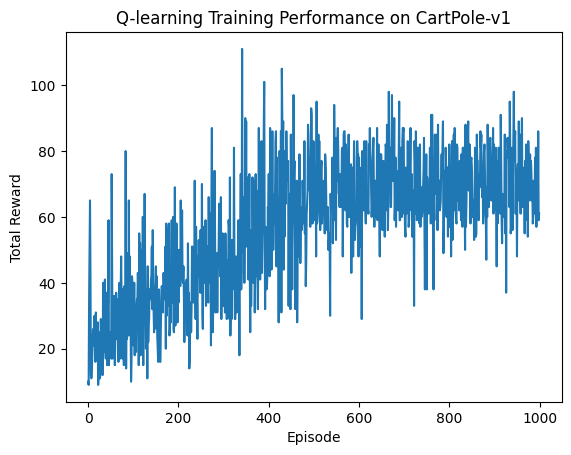

In [18]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

# Create the CartPole-v1 environment
env = gym.make('CartPole-v1')

# Set the seed for reproducibility
env.seed(42)
np.random.seed(42)
random.seed(42)

class QLearningAgent:
    def __init__(self, state_bins, action_size):
        self.state_bins = state_bins
        self.action_size = action_size
        self.q_table = np.zeros(tuple(len(bins) + 1 for bins in state_bins) + (action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.99
        self.exploration_rate = 1.0
        self.exploration_decay = 0.995
        self.exploration_min = 0.01

    def get_discrete_state(self, state):
        discrete_state = []
        for i in range(len(state)):
            discrete_state.append(np.digitize(state[i], self.state_bins[i]) - 1)
        return tuple(discrete_state)

    def choose_action(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.choice(range(self.action_size))
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action] * (not done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
        if done:
            self.exploration_rate = max(self.exploration_min, self.exploration_rate * self.exploration_decay)

state_bins = [
    np.linspace(-2.4, 2.4, 10),  # Cart position
    np.linspace(-3.0, 3.0, 10),  # Cart velocity
    np.linspace(-0.5, 0.5, 10),  # Pole angle
    np.linspace(-2.0, 2.0, 10)   # Pole velocity at tip
]

# Initialize the Q-learning agent
agent = QLearningAgent(state_bins=state_bins, action_size=env.action_space.n)

# Training parameters
num_episodes = 1000
max_steps = 200
rewards = []

for episode in range(num_episodes):
    state = env.reset()
    state = agent.get_discrete_state(state)
    total_reward = 0

    for step in range(max_steps):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = agent.get_discrete_state(next_state)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break

    rewards.append(total_reward)
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Total Reward: {total_reward}")

print("Training finished.\n")

# Plot the results
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Training Performance on CartPole-v1')
plt.show()

### Practical 10a FussyLogic_for_WashingMachine ###

In [21]:
!pip install scikit-fuzzy
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Define input variables
dirtiness = ctrl.Antecedent(np.arange(0, 11, 1), 'dirtiness')
fabric_type = ctrl.Antecedent(np.arange(0, 11, 1), 'fabric_type')
load_size = ctrl.Antecedent(np.arange(0, 11, 1), 'load_size')

# Define output variable
washing_time = ctrl.Consequent(np.arange(0, 61, 1), 'washing_time')

# Define membership functions
dirtiness['low'] = fuzz.trimf(dirtiness.universe, [0, 0, 5])
dirtiness['medium'] = fuzz.trimf(dirtiness.universe, [0, 5, 10])
dirtiness['high'] = fuzz.trimf(dirtiness.universe, [5, 10, 10])

fabric_type['delicate'] = fuzz.trimf(fabric_type.universe, [0, 0, 5])
fabric_type['normal'] = fuzz.trimf(fabric_type.universe, [0, 5, 10])
fabric_type['tough'] = fuzz.trimf(fabric_type.universe, [5, 10, 10])

load_size['small'] = fuzz.trimf(load_size.universe, [0, 0, 5])
load_size['medium'] = fuzz.trimf(load_size.universe, [0, 5, 10])
load_size['large'] = fuzz.trimf(load_size.universe, [5, 10, 10])

washing_time['short'] = fuzz.trimf(washing_time.universe, [0, 0, 30])
washing_time['medium'] = fuzz.trimf(washing_time.universe, [0, 30, 60])
washing_time['long'] = fuzz.trimf(washing_time.universe, [30, 60, 60])

# Define fuzzy rules
rule1 = ctrl.Rule(dirtiness['low'] & fabric_type['delicate'], washing_time['short'])
rule2 = ctrl.Rule(dirtiness['medium'] & fabric_type['normal'] & load_size['small'], washing_time['short'])
rule3 = ctrl.Rule(dirtiness['medium'] & fabric_type['normal'] & load_size['medium'], washing_time['medium'])
rule4 = ctrl.Rule(dirtiness['medium'] & fabric_type['normal'] & load_size['large'], washing_time['long'])
rule5 = ctrl.Rule(dirtiness['high'] | fabric_type['tough'], washing_time['long'])

# Create control system
washing_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
washing_sim = ctrl.ControlSystemSimulation(washing_ctrl)

# Define inputs
washing_sim.input['dirtiness'] = 7
washing_sim.input['fabric_type'] = 8
washing_sim.input['load_size'] = 6

# Compute the washing time
washing_sim.compute()
print("Recommended washing time:", washing_sim.output["washing_time"], "minutes")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=bf7a4ab793f06ee56e19592a4410361f76c9a9c71af2d4804bf3fea4c3e2ba40
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


/usr/local/lib/python3.10/dist-packages/skfuzzy/image/__init__.py:17: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) > LooseVersion("1.8"):


Recommended washing time: 35.268292682926806 minutes


### Practical 10b FussyLogic_for_AC ###

In [22]:
!pip install scikit-fuzzy
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Define input variables
temperature = ctrl.Antecedent(np.arange(0, 101, 1), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')

# Define output variable
cooling_power = ctrl.Consequent(np.arange(0, 101, 1), 'cooling_power')

# Define membership functions
temperature['cold'] = fuzz.trimf(temperature.universe, [0, 0, 50])
temperature['comfortable'] = fuzz.trimf(temperature.universe, [20, 50, 80])
temperature['hot'] = fuzz.trimf(temperature.universe, [50, 100, 100])

humidity['low'] = fuzz.trimf(humidity.universe, [0, 0, 50])
humidity['comfortable'] = fuzz.trimf(humidity.universe, [20, 50, 80])
humidity['high'] = fuzz.trimf(humidity.universe, [50, 100, 100])

cooling_power['low'] = fuzz.trimf(cooling_power.universe, [0, 0, 50])
cooling_power['medium'] = fuzz.trimf(cooling_power.universe, [0, 50, 100])
cooling_power['high'] = fuzz.trimf(cooling_power.universe, [50, 100, 100])

# Define fuzzy rules
rule1 = ctrl.Rule(temperature['cold'] & humidity['low'], cooling_power['high'])
rule2 = ctrl.Rule(temperature['cold'] & humidity['high'], cooling_power['medium'])
rule3 = ctrl.Rule(temperature['comfortable'] & humidity['comfortable'], cooling_power['medium'])
rule4 = ctrl.Rule(temperature['hot'] & humidity['high'], cooling_power['high'])
rule5 = ctrl.Rule(temperature['hot'] & humidity['low'], cooling_power['low'])

# Create control system
ac_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
ac_sim = ctrl.ControlSystemSimulation(ac_ctrl)

# Define inputs
ac_sim.input['temperature'] = 75
ac_sim.input['humidity'] = 40

# Compute the cooling power
ac_sim.compute()

# Print the result
print("Cooling Power:", ac_sim.output['cooling_power'])

Cooling Power: 45.78471421042893


### Practical 10c FussyLogic_for_Railway ###

In [23]:
!pip install scikit-fuzzy
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Define input variables
distance_to_station = ctrl.Antecedent(np.arange(0, 101, 1), 'distance_to_station')
speed_limit = ctrl.Antecedent(np.arange(0, 101, 1), 'speed_limit')

# Define output variable
train_speed = ctrl.Consequent(np.arange(0, 101, 1), 'train_speed')

# Define membership functions
distance_to_station['close'] = fuzz.trimf(distance_to_station.universe, [0, 0, 50])
distance_to_station['medium'] = fuzz.trimf(distance_to_station.universe, [0, 50, 100])
distance_to_station['far'] = fuzz.trimf(distance_to_station.universe, [50, 100, 100])

speed_limit['slow'] = fuzz.trimf(speed_limit.universe, [0, 0, 50])
speed_limit['medium'] = fuzz.trimf(speed_limit.universe, [0, 50, 100])
speed_limit['fast'] = fuzz.trimf(speed_limit.universe, [50, 100, 100])

train_speed['slow'] = fuzz.trimf(train_speed.universe, [0, 0, 50])
train_speed['medium'] = fuzz.trimf(train_speed.universe, [0, 50, 100])
train_speed['fast'] = fuzz.trimf(train_speed.universe, [50, 100, 100])

# Define fuzzy rules
rule1 = ctrl.Rule(distance_to_station['close'], train_speed['slow'])
rule2 = ctrl.Rule(distance_to_station['medium'] & speed_limit['medium'], train_speed['medium'])
rule3 = ctrl.Rule(distance_to_station['far'] | speed_limit['fast'], train_speed['fast'])

# Create control system
train_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
train_sim = ctrl.ControlSystemSimulation(train_ctrl)

# Define inputs
train_sim.input['distance_to_station'] = 30
train_sim.input['speed_limit'] = 70

# Compute the train speed
train_sim.compute()

# Print the result
print("Recommended Train Speed:", train_sim.output['train_speed'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Recommended Train Speed: 49.999999999999986


### Practical 10d Decision tree from scratch ###

In [24]:
import numpy as np

class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Stopping criteria
        if (depth == self.max_depth) or (num_classes == 1):
            return np.bincount(y).argmax()

        # Find best split
        best_split = self._find_best_split(X, y)

        if best_split is None:
            return np.bincount(y).argmax()

        feature_idx, threshold = best_split
        left_indices = X[:, feature_idx] <= threshold
        right_indices = ~left_indices

        # Recursively build tree
        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (feature_idx, threshold, left_tree, right_tree)

    def _find_best_split(self, X, y):
        best_split = None
        best_gini = float('inf')
        num_samples, num_features = X.shape

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_indices = X[:, feature_idx] <= threshold
                right_indices = ~left_indices

                gini = self._calculate_gini_index(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_split = (feature_idx, threshold)

        return best_split

    def _calculate_gini_index(self, left_labels, right_labels):
        total_samples = len(left_labels) + len(right_labels)
        p_left = len(left_labels) / total_samples
        p_right = len(right_labels) / total_samples

        gini_left = 1 - sum([(np.sum(left_labels == c) / len(left_labels)) ** 2 for c in np.unique(left_labels)])
        gini_right = 1 - sum([(np.sum(right_labels == c) / len(right_labels)) ** 2 for c in np.unique(right_labels)])

        gini_index = p_left * gini_left + p_right * gini_right
        return gini_index

    def predict(self, X):
        predictions = np.array([self._traverse_tree(x, self.tree) for x in X])
        return predictions

    def _traverse_tree(self, x, node):
        if isinstance(node, np.int64):
            return node

        feature_idx, threshold, left_tree, right_tree = node
        if x[feature_idx] <= threshold:
            return self._traverse_tree(x, left_tree)
        else:
            return self._traverse_tree(x, right_tree)

    def print_tree(self):
        self._print_node(self.tree)

    def _print_node(self, node, depth=0):
        if isinstance(node, np.int64):
            print("  " * depth, "Class:", node)
        else:
            feature_idx, threshold, left_tree, right_tree = node
            print("  " * depth, f"Feature {feature_idx} <= {threshold}")
            print("  " * (depth + 1), "Left:")
            self._print_node(left_tree, depth + 1)
            print("  " * (depth + 1), "Right:")
            self._print_node(right_tree, depth + 1)

# Example usage
X_train = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
y_train = np.array([0, 0, 1, 1])

# Initialize and train the decision tree classifier
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train)

# Print decision tree structure
print("Decision Tree Structure:")
clf.print_tree()

# Predictions
X_test = np.array([[2, 2], [3, 3]])
predictions = clf.predict(X_test)
print("Predictions:", predictions)

Decision Tree Structure:
 Feature 0 <= 2
   Left:
   Class: 0
   Right:
   Class: 1
Predictions: [0 1]
